In [1]:
import operator
from typing import TypedDict, Literal, Annotated
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel, Field
from dotenv import load_dotenv, find_dotenv

In [2]:
load_dotenv(find_dotenv())

True

In [3]:
class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(
        ..., description="Final evaluation result."
    )
    feedback: str = Field(..., description="feedback for the tweet.")

In [4]:
generator_llm = ChatOpenAI(model="gpt-4o", temperature=0)
evaluator_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
optimizer_llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [5]:
class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int
    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [6]:
def generate_tweet(state: TweetState):
    prompt = [
        SystemMessage(content="you are a funny and clever Twitter/X influencer"),
        HumanMessage(
            content=f"""
    Write a short, original, and hilarious tweet on the topic: {state["topic"]}.
    Rules:
    - Do NOT use the question-answer format.
    - Max output should be of 280 characters.
    - Use observational humor, irony, sarcasm, or cultural references.
    - Think in meme logic, punchlines, or relatable takes.
    - Use simple, day to day english.
"""
        ),
    ]
    response = generator_llm.invoke(prompt).content
    return {"tweet": response, 'tweet_history': [response]}

In [7]:
def evaluate_tweet(state: TweetState):
    # prompt
    messages = [
        SystemMessage(
            content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."
        ),
        HumanMessage(
            content=f"""
Evaluate the following tweet:

Tweet: "{state["tweet"]}"

Use the criteria below to evaluate the tweet:

1. Originality: Is this fresh, or have you seen it a hundred times before?  
2. Humor: Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness: Is it short, sharp, and scroll-stopping?  
4. Virality Potential: Would people retweet or share it?  
5. Format: Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
"""
        ),
    ]

    response = structured_evaluator_llm.invoke(messages)

    return {
        "evaluation": response.evaluation,
        "feedback": response.feedback,
        "feedback_history": [response.feedback]
    }

In [8]:
def optimize_tweet(state: TweetState):
    messages = [
        SystemMessage(
            content="You punch up tweets for virality and humor based on given feedback."
        ),
        HumanMessage(
            content=f"""
Improve the tweet based on this feedback:
"{state["feedback"]}"

Topic: "{state["topic"]}"
Original Tweet:
{state["tweet"]}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
"""
        ),
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state["iteration"] + 1

    return {"tweet": response, "iteration": iteration, 'tweet_history': [response]}

In [9]:
def route_evaluation(state: TweetState):
    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvements'

In [10]:
graph = StateGraph(state_schema=TweetState)
graph.add_node('generate_tweet', generate_tweet)
graph.add_node('evaluate_tweet', evaluate_tweet)
graph.add_node('optimize_tweet', optimize_tweet)

graph.add_edge(START, 'generate_tweet')
graph.add_edge('generate_tweet', 'evaluate_tweet')
graph.add_conditional_edges(
    'evaluate_tweet',
    route_evaluation,
    {
        'approved': END,
        'needs_improvements': 'optimize_tweet'
    }
)
graph.add_edge('optimize_tweet', 'evaluate_tweet')
graph = graph.compile()

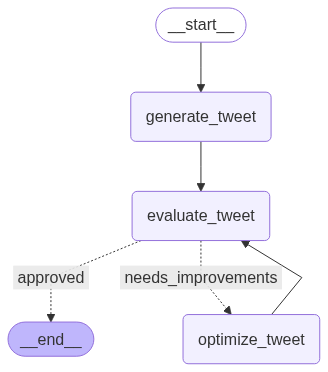

In [11]:
graph

In [12]:
initial_state = {
    'topic': 'Indian Railways',
    'iteration': 1,
    'max_iteraion': 5
}

graph.invoke(initial_state)

{'topic': 'Indian Railways',
 'tweet': "Indian Railways: where the train is always on time... in an alternate universe. Here, it's like a surprise party—never when you expect it, but when it arrives, everyone’s just happy it showed up. #TrainTales #IndianRailwaysLogic",
 'evaluation': 'approved',
 'feedback': 'This tweet showcases originality by creatively comparing Indian Railways to a surprise party, which is a fresh perspective. The humor is subtle yet effective, likely eliciting a chuckle from those familiar with the unpredictability of train schedules. The punchiness is decent, though it could be slightly more concise to enhance its scroll-stopping potential. The use of hashtags is appropriate and adds to its virality potential, as it taps into a relatable experience for many. Overall, it is well-formed and adheres to the character limit, making it a strong tweet.',
 'iteration': 1,
 'tweet_history': ["Indian Railways: where the train is always on time... in an alternate universe.